In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import matplotlib.lines as lines
from tqdm.notebook import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

#from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Оценка полиси методом Монте Карло

Берем случайное начальное состояние, потом используя полиси доигрываем эпизод и используем награду для оценки состояния

In [2]:
# game const
NUMBER_STATES = 640 
NUMBER_ACTIONS = 2

ACTION_STICK = 0
ACTION_HIT = 1

def transfom_state_to_id(state):
    state_id = (state[0] - 1) + 32 * state[2] + 64 * (state[1] - 1) 
    return state_id

def get_state_id(env):
    return transfom_state_to_id(env._get_obs())


def transfom_id_to_state(state_id):
    state = ((state_id % 32) + 1,
             (state_id // 64) + 1,
             ((state_id // 32) % 2) == 1,
            )
    return state

In [91]:
# проверки
print( transfom_state_to_id( (3, 7, True) ), transfom_id_to_state(590))

418 (15, 10, False)


In [3]:
def get_random_V(env):
    V = np.random.random(NUMBER_STATES)
    #V[final_states] = 0.0
    return V

def get_random_Q(env):
    Q = np.random.random(size=(NUMBER_STATES, NUMBER_ACTIONS))
    #Q[final_states, :] = 0.0
    return Q

In [4]:
def get_simle_policy():
    pi = np.zeros(NUMBER_STATES, dtype = int)
    for state_id in range(NUMBER_STATES):
        state = transfom_id_to_state(state_id)
        if state[0] >= 19:
            pi[state_id] = ACTION_STICK
        else:
            pi[state_id] = ACTION_HIT
        
    return pi

def get_random_policy():
    pi = np.random.randint(0, 2, NUMBER_STATES)
    return pi

In [5]:
def monto_carlo_expectation(env, pi, total_episodes = 100000, gamma = 1.00, verbose = False):

    def run_episode(env, pi):
        env.reset()
        states, rewards = [get_state_id(env)], [0]
        for _ in range(1000):
            action = pi[get_state_id(env)]
            observation, reward, done, info = env.step(action)
            states.append(transfom_state_to_id(observation))
            rewards.append(reward)
            if done:
                break
        return states, rewards

    sum_total_rewards = 0
    all_rewards = []
    for i in range(total_episodes):
        states, rewards = run_episode(env, pi)
        r = np.sum(rewards)
        sum_total_rewards += r
        all_rewards.append(r)

        if i % 200000 == 100000 and verbose:
            print('step: {}  reward: {:2.4f} +-{:2.5f}'.format(i, sum_total_rewards / (i + 1), np.std(all_rewards)/np.sqrt(len(all_rewards))))
    
    return sum_total_rewards / total_episodes, np.std(all_rewards)/np.sqrt(len(all_rewards))

Оценим качество простой стратегии: говорить stand, если у нас на рукахкомбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit

In [6]:
# Окружение для данного раздела
env = gym.make('Blackjack-v0', natural = True)

In [14]:
pi = get_simle_policy()
expect = monto_carlo_expectation(env, pi, total_episodes = 5000000, verbose = True)

step: 100000  reward: -0.1786 +-0.00307
step: 300000  reward: -0.1802 +-0.00177
step: 500000  reward: -0.1798 +-0.00137
step: 700000  reward: -0.1800 +-0.00116
step: 900000  reward: -0.1797 +-0.00102
step: 1100000  reward: -0.1797 +-0.00093
step: 1300000  reward: -0.1795 +-0.00085
step: 1500000  reward: -0.1794 +-0.00079
step: 1700000  reward: -0.1797 +-0.00075
step: 1900000  reward: -0.1801 +-0.00070
step: 2100000  reward: -0.1802 +-0.00067
step: 2300000  reward: -0.1802 +-0.00064
step: 2500000  reward: -0.1799 +-0.00061
step: 2700000  reward: -0.1800 +-0.00059
step: 2900000  reward: -0.1798 +-0.00057
step: 3100000  reward: -0.1799 +-0.00055
step: 3300000  reward: -0.1801 +-0.00053
step: 3500000  reward: -0.1803 +-0.00052
step: 3700000  reward: -0.1801 +-0.00051
step: 3900000  reward: -0.1801 +-0.00049
step: 4100000  reward: -0.1802 +-0.00048
step: 4300000  reward: -0.1802 +-0.00047
step: 4500000  reward: -0.1800 +-0.00046
step: 4700000  reward: -0.1799 +-0.00045
step: 4900000  reward

In [15]:
print(f"Cредний результат стратегии {expect[0]:2.4f} +- {expect[1]:2.4f}")

Cредний результат стратегии -0.1797 +- 0.0004


## Часть первая


Простой вариант стратении.
Ниже реализованы методы обучения Monte Carlo Control и q-learning

In [7]:
class Control_runner():
    def __init__(self, total_episodes = 100000, gamma = 1.00, eps_value = 0.05, alpha_mean = 0.00001, alpha_Q = 0.00001,
                 off_policy = False, verbose = False, window_episodes = 100000):
        self.total_episodes = total_episodes
        self.gamma = gamma
        self.alpha_mean = alpha_mean
        self.alpha_Q = alpha_Q
        self.pi = get_random_policy()
        self.Q = np.zeros((NUMBER_STATES, NUMBER_ACTIONS))
        self.Q_n_visits = np.zeros((NUMBER_STATES, NUMBER_ACTIONS))
        self.mean_total_reward_pi_eps = 0
        self.mean_total_reward_pi = 0
        self.num_total_reward_pi_eps = 0
        self.num_total_reward_pi = 0
        self.mean_rewards_log = []
        self.eps_value = eps_value
        self.off_policy = off_policy
        self.verbose = verbose
        self.window_episodes = window_episodes
        
    def generate_next_action(self, env, clear_expectation):

        state_id = get_state_id(env)
        if np.random.rand() > self.eps_value:
            next_action = self.pi[state_id]
        else:
            next_action = np.random.randint(NUMBER_ACTIONS)
            if next_action != self.pi[state_id]:
                clear_expectation = False
                # print(f'next_action: {next_action}, pi: {self.pi[state_id]}, state_id: {state_id}')
            
            
        return state_id, next_action, clear_expectation
    
    
    def compute_policy_by_Q(self):
        self.pi = np.argmax( self.Q, axis=1 )

    def run_episode(self, env):
        
        env.reset()
        
        clear_expectation = True
        state_id, next_action, clear_expectation = self.generate_next_action(env, clear_expectation)

        states, actions, rewards = [state_id], [next_action], [0]
        for _ in range(1000):
            observation, reward, done, info = env.step(next_action)
            
            state_id, next_action, clear_expectation = self.generate_next_action(env, clear_expectation)
            states.append(state_id)
            actions.append(next_action)
            rewards.append(reward)
            
            if done:
                break
                
        return states, actions, rewards, clear_expectation        
    
    def update_Q_on_policy(self, states, actions, rewards):
        pass 

    def update_Q_off_policy(self, states, actions, rewards):
        pass
    
    def run(self, env, total_episodes = None, gamma = None, eps_value = None, alpha_mean = None, alpha_Q = None):
        
        if total_episodes is not None:
            self.total_episodes = total_episodes
        if gamma is not None:
            self.gamma = gamma            
        if eps_value is not None:
            self.eps_value = eps_value
        if alpha_mean is not None:
            self.alpha_mean = alpha_mean
        if alpha_Q is not None:
            self.alpha_Q = alpha_Q
        self.prob_best_action = 1 - self.eps_value * (NUMBER_ACTIONS-1) / NUMBER_ACTIONS    
            
            
        for i in range(self.total_episodes):
            states, actions, rewards, clear_expectation = self.run_episode(env)

            # print(states, actions, rewards, clear_expectation)
            
            self.num_total_reward_pi_eps += 1
            if self.alpha_mean * self.num_total_reward_pi_eps < 1:
                alpha = 1 / self.num_total_reward_pi_eps
            else:
                alpha = self.alpha_mean
            self.mean_total_reward_pi_eps = (1 - alpha) * self.mean_total_reward_pi_eps + alpha * np.sum(rewards)
            
            
            if clear_expectation:
                self.num_total_reward_pi += self.prob_best_action ** (len(actions) - 1)
                if self.alpha_mean * self.num_total_reward_pi < 1:
                    alpha = 1 / self.num_total_reward_pi
                else:
                    alpha = self.alpha_mean
                # shift distribution correction 1 / (1 - eps_real)^ (n_step - 1)
                # alpha = alpha / ((1 - self.eps_value * (NUMBER_ACTIONS-1) / NUMBER_ACTIONS) ** (len(actions) - 2))  
                
                self.mean_total_reward_pi = (1 - alpha) * self.mean_total_reward_pi + alpha * np.sum(rewards)

            self.mean_rewards_log.append(self.mean_total_reward_pi) # оценка по чистой pi стратегии для графиков    
            
            if self.off_policy:
                self.update_Q_off_policy(states, actions, rewards)
            else:
                self.update_Q_on_policy(states, actions, rewards)

            if i % 1000 == 0:
                self.compute_policy_by_Q()

            if i % self.window_episodes == self.window_episodes - 1 and self.verbose:
                print(f'step: {i} reward pi_eps: {self.mean_total_reward_pi_eps:2.4f}, reward pi: {self.mean_total_reward_pi:2.4f}')
                
class Monte_carlo_control_runner(Control_runner):
    
    def update_Q_on_policy(self, states, actions, rewards):
      
        g = 0
      
        for t in range(len(states)-2, -1, -1):
            g =  g * self.gamma + rewards[t+1]

            self.Q_n_visits[states[t]][actions[t]] += 1
            if self.Q_n_visits[states[t]][actions[t]] * self.alpha_Q < 1:
                alpha = 1 / self.Q_n_visits[states[t]][actions[t]]
            else:
                alpha = self.alpha_Q
            self.Q[states[t]][actions[t]] = (1 - alpha) * self.Q[states[t]][actions[t]] + alpha * g   

    
    def update_Q_off_policy(self, states, actions, rewards):
            
        g = 0
 
        w = 1
        prob_best_action = 1 - self.eps_value * (NUMBER_ACTIONS-1) / NUMBER_ACTIONS
        for t in range(len(states)-2, -1, -1):
            if self.pi[states[t+1]] != actions[t+1]:
                # print(f'stop update {t}, {states}, {actions}, {rewards}')
                break
            # else:
            #    print(f'update t {t}, states {states[t]}, states {actions[t]}')
            g =  g * self.gamma + rewards[t+1]
            w = w / self.prob_best_action 
            
            self.Q_n_visits[states[t]][actions[t]] += w
            if self.Q_n_visits[states[t]][actions[t]] * self.alpha_Q < 1:
                alpha = 1 / self.Q_n_visits[states[t]][actions[t]]
            else:
                alpha = self.alpha_Q
              
            alpha = alpha * w   
            self.Q[states[t]][actions[t]] = (1 - alpha) * self.Q[states[t]][actions[t]] + alpha * g   
        
        
class Td_learning_runner(Control_runner):

    def update_Q_on_policy(self, states, actions, rewards):

        t = len(states) - 2
        self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                        self.alpha_Q * (rewards[t+1])     
        
        for t in range(len(states)-3, -1, -1):
            self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                            self.alpha_Q * (rewards[t+1] + self.gamma * self.Q[states[t+1]][actions[t+1]])

    def update_Q_off_policy(self, states, actions, rewards):
        
        t = len(states) - 2
        self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                self.alpha_Q * (rewards[t+1])      
        
        for t in range(len(states)-3, -1, -1):
            self.Q[states[t]][actions[t]] = (1 - self.alpha_Q) * self.Q[states[t]][actions[t]] + \
                    self.alpha_Q * (rewards[t+1]  + self.gamma * np.max( self.Q[states[t+1]] ))
                

In [9]:
env = gym.make('Blackjack-v0', natural = True)

In [10]:
monte_carlo_model = Monte_carlo_control_runner(off_policy = True, window_episodes = 500000, verbose = True)

In [12]:
# Одиночный запуск
%time
monte_carlo_model.run(env, total_episodes = 10000000, eps_value = 0.10, alpha_mean = 0.000002)

Wall time: 0 ns
step: 499999 reward pi_eps: -0.0760, reward pi: -0.0398
step: 999999 reward pi_eps: -0.0681, reward pi: -0.0316
step: 1499999 reward pi_eps: -0.0668, reward pi: -0.0299
step: 1999999 reward pi_eps: -0.0652, reward pi: -0.0283
step: 2499999 reward pi_eps: -0.0640, reward pi: -0.0272
step: 2999999 reward pi_eps: -0.0635, reward pi: -0.0265
step: 3499999 reward pi_eps: -0.0634, reward pi: -0.0265
step: 3999999 reward pi_eps: -0.0628, reward pi: -0.0256
step: 4499999 reward pi_eps: -0.0623, reward pi: -0.0249
step: 4999999 reward pi_eps: -0.0642, reward pi: -0.0260
step: 5499999 reward pi_eps: -0.0640, reward pi: -0.0266
step: 5999999 reward pi_eps: -0.0632, reward pi: -0.0261
step: 6499999 reward pi_eps: -0.0622, reward pi: -0.0255
step: 6999999 reward pi_eps: -0.0633, reward pi: -0.0253
step: 7499999 reward pi_eps: -0.0626, reward pi: -0.0244
step: 7999999 reward pi_eps: -0.0634, reward pi: -0.0255
step: 8499999 reward pi_eps: -0.0628, reward pi: -0.0253
step: 8999999 rew

In [97]:
# Проверка качества оценивания налету с помощью монте карло оценки финальной модели
ex = monto_carlo_expectation(env, monte_carlo_model.pi, total_episodes = 2000000)
print(f'Cредний результат стратегии {ex[0]:2.4f} +- {ex[1]:2.4f}')

Cредний результат стратегии -0.0265 +- 0.0007


(-0.1, -0.02)

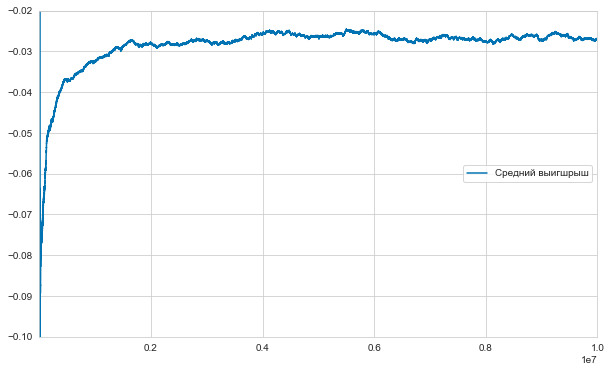

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1, len(monte_carlo_model.mean_rewards_log)+ 1), monte_carlo_model.mean_rewards_log, 
        label="Средний выигшрыш", color="C0")

ax.legend(loc="center right")
ax.set_xlim((1, len(monte_carlo_model.mean_rewards_log)+1))
ax.set_ylim((-0.1, -0.02))

(-0.03, -0.02)

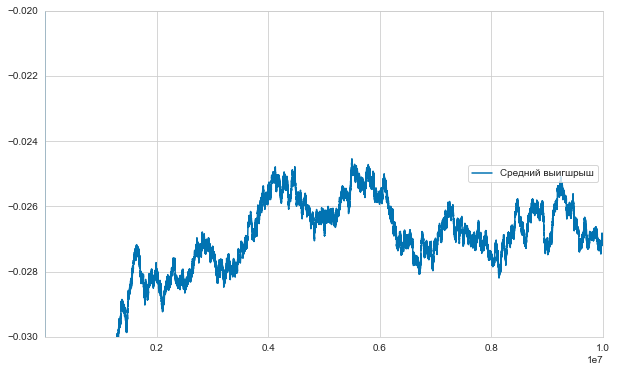

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1, len(monte_carlo_model.mean_rewards_log)+ 1), monte_carlo_model.mean_rewards_log, 
        label="Средний выигшрыш", color="C0")

ax.legend(loc="center right")
ax.set_xlim((1, len(monte_carlo_model.mean_rewards_log)+1))
ax.set_ylim((-0.03, -0.02))

### Подбор оптимальных параметров

### Сравнение кривых обучения для одного набора параметров

In [439]:

monte_carlo_model = Monte_carlo_control_runner(alpha_mean = 0.00001, off_policy = True, verbose = False)

total_episodes = 1000000

models = []
  
for _ in tqdm(range(5)): 
    monte_carlo_model = Monte_carlo_control_runner(total_episodes = total_episodes, eps_value = 0.05, alpha_mean = 0.00001)
    monte_carlo_model.run(env)
    models.append(monte_carlo_model)

(-0.2, -0.04)

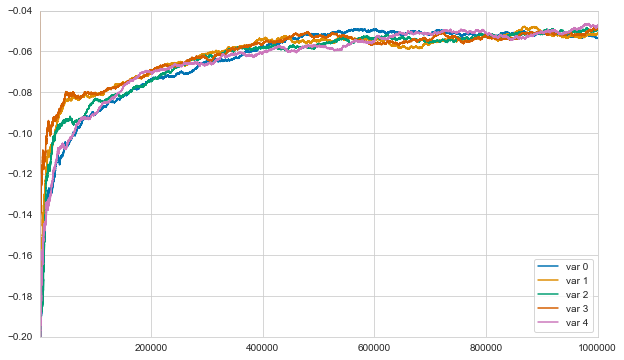

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(models[0].mean_rewards_log)+ 1

for i, model in enumerate(models): 
    ax.plot(np.arange(1, max_x), model.mean_rewards_log, 
            label=f"var {i}", color=f"C{i}")

ax.legend(loc="lower right")
ax.set_xlim((100, max_x))
ax.set_ylim((-0.2, -0.04))

Как зависит результа обучения от выбора eps.

In [26]:
monte_carlo_model = Monte_carlo_control_runner(alpha_mean = 0.00001, off_policy = True, verbose = False)

In [27]:
total_episodes = 2000000
eps_list = [0.5, 0.25, 0.1, 0.05, 0.02]

models = []
for eps in tqdm(eps_list): 
    monte_carlo_model = Monte_carlo_control_runner(total_episodes = total_episodes, eps_value = eps, alpha_mean = 0.000001)
    monte_carlo_model.run(env)
    models.append(monte_carlo_model)

In [29]:
# Оценка итоговой модели
total_episodes = 2000000
model_expectations = []

for model in tqdm(models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    model_expectations.append(expectation_i)

(-0.2, -0.04)

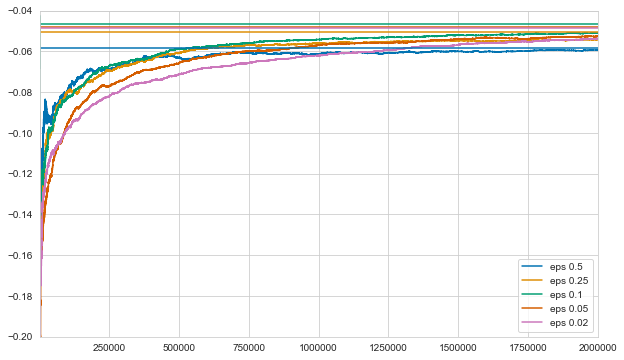

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(models[0].mean_rewards_log)+ 1

for i, [eps, model] in enumerate(zip(eps_list, models)): 
    ax.plot(np.arange(1, max_x), model.mean_rewards_log, 
            label=f"eps {eps}", color=f"C{i}")

for i, [eps, [expectation_i, std_i]] in enumerate(zip(eps_list, model_expectations)):
    l = lines.Line2D([1,max_x], [expectation_i, expectation_i], color=f"C{i}")
    ax.add_line(l)

ax.legend(loc="lower right")
ax.set_xlim((100, max_x))
ax.set_ylim((-0.2, -0.04))

(-0.08, -0.04)

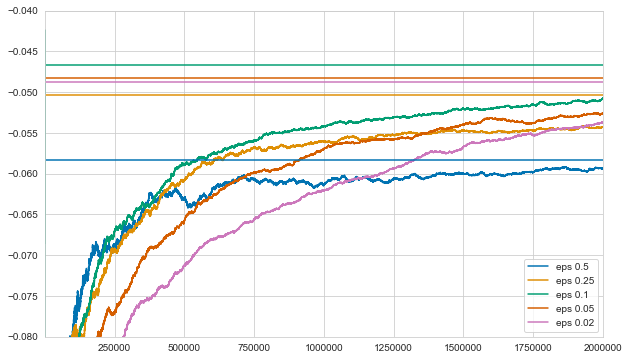

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(models[0].mean_rewards_log)+ 1

for i, [eps, model] in enumerate(zip(eps_list, models)): 
    ax.plot(np.arange(1, max_x), model.mean_rewards_log, 
            label=f"eps {eps}", color=f"C{i}")

for i, [eps, [expectation_i, std_i]] in enumerate(zip(eps_list, model_expectations)):
    l = lines.Line2D([1,max_x], [expectation_i, expectation_i], color=f"C{i}")
    ax.add_line(l)

ax.legend(loc="lower right")
ax.set_xlim((100, max_x))
ax.set_ylim((-0.08, -0.04))

In [31]:
model_expectations

[(-0.0582925, 0.0006761077889078598),
 (-0.0503955, 0.0006745605212209465),
 (-0.0466765, 0.0006733957990467974),
 (-0.0482635, 0.0006718776430897779),
 (-0.0486945, 0.0006722906163519425)]

### Как зависит результа обучения от выбора alpha_Q

In [13]:
total_episodes = 1000000
num_runs = 10
nqlist0 = [500, 1000, 10000, 30000, 100000, 200000]
nq_list = nqlist0 * num_runs

q_models = []
for nq in tqdm(nq_list): 
    monte_carlo_model = Monte_carlo_control_runner(off_policy = True, total_episodes = total_episodes, eps_value = 0.05, 
                                                   alpha_Q = 1/nq, alpha_mean = 0.00001)
    monte_carlo_model.run(env)
    q_models.append(monte_carlo_model)
    

In [14]:
total_episodes = 4000000
for i, model in enumerate(tqdm(q_models)): 
    model.run(env, total_episodes = total_episodes, alpha_mean = 0.000001)
    q_models[i] = model

In [15]:
# Оценка итоговой модели
total_episodes = 1000000
q_model_expectations = []

for model in tqdm(q_models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    q_model_expectations.append(expectation_i)

In [32]:
nq = len(nqlist0)
q_total_expectations = [[] for _ in range(nq)]
for i, (expectation, std) in zip(list(range(nq)) * num_runs, q_model_expectations):
    if len(q_total_expectations[i]) == 0:
        q_total_expectations[i] = [expectation]
    else:
        q_total_expectations[i] = q_total_expectations[i] + [expectation]

print("Expectation")
for i in range(len(nqlist0)):       
    expectation = np.mean(q_total_expectations[i])
    print(f'for alpha_Q: {1 / nqlist0[i]:1.7f}  final reward: {expectation:2.4f}')

Expectation
for alpha_Q: 0.0020000  final reward: -0.0271
for alpha_Q: 0.0010000  final reward: -0.0262
for alpha_Q: 0.0001000  final reward: -0.0256
for alpha_Q: 0.0000333  final reward: -0.0265
for alpha_Q: 0.0000100  final reward: -0.0258
for alpha_Q: 0.0000050  final reward: -0.0260


In [29]:
# Для гафиков
rewards = [[] for _ in range(nq)]
for i, model in zip(list(range(nq)) * num_runs, q_models):
    if len(rewards[i]) == 0:
        rewards[i] = np.array(model.mean_rewards_log)
    else:
        rewards[i] = rewards[i] + np.array(model.mean_rewards_log)
        
for i in range(nq):       
    rewards[i] = rewards[i] / num_runs

(-0.04, -0.02)

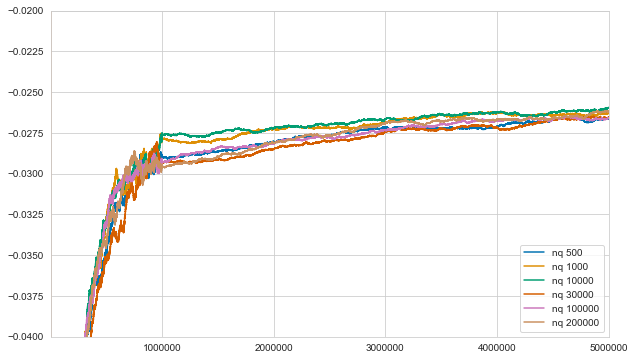

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(rewards[0])+ 1

for i in range(nq): 
    ax.plot(np.arange(1, max_x), rewards[i], 
            label=f"nq {nqlist0[i]}", color=f"C{i}")

ax.legend(loc="lower right")
ax.set_xlim((10, max_x))
ax.set_ylim((-0.04, -0.02))

Парамер практически не влияет ни скорость обучения ни на качество модели итоговой модели

### Сравнение Monte Carlo Control  и TD - обучения в on-policy и off-policy вариантах

In [100]:
total_episodes = 2000000
num_runs = 20 # Число запусков

# total_episodes = 20000
# num_runs = 5 # Число запусков

mc_on_models = []
mc_off_models = []

for nq in tqdm(range(num_runs)): 
    # Monte Carlo Control on-policy
    monte_carlo_model = Monte_carlo_control_runner(total_episodes = total_episodes, eps_value = 0.1, off_policy = False,
                                                   alpha_mean = 0.00001)
    monte_carlo_model.run(env)
    mc_on_models.append(monte_carlo_model)
    
    # Monte Carlo Control off-policy
    monte_carlo_model = Monte_carlo_control_runner(total_episodes = total_episodes, eps_value = 0.1, off_policy = True,
                                                   alpha_mean = 0.00001)
    monte_carlo_model.run(env)
    mc_off_models.append(monte_carlo_model)   
     
    

In [ ]:
td_on_models = []
td_off_models = []

for nq in tqdm(range(num_runs)): 

    # td-learning on-policy
    td_model = Td_learning_runner(total_episodes = total_episodes, eps_value = 0.1, alpha_Q = 0.0001, off_policy = False,
                                                   alpha_mean = 0.00001)
    td_model.run(env)
    td_on_models.append(td_model)       
    
    # td-learning on-policy
    td_model = Td_learning_runner(total_episodes = total_episodes, eps_value = 0.1, alpha_Q = 0.0001, off_policy = True,
                                                   alpha_mean = 0.00001)
    td_model.run(env)
    td_off_models.append(td_model)     

In [101]:
# Дообучим модели с более гладкой оценкой
#total_episodes = 2000

for i, model in enumerate(tqdm(mc_on_models)): 
    model.run(env, total_episodes = total_episodes, alpha_mean = 0.000001)
    mc_on_models[i] = model
    
for i, model in enumerate(tqdm(mc_off_models)): 
    model.run(env, total_episodes = total_episodes, alpha_mean = 0.000001)
    mc_off_models[i] = model

In [ ]:
for i, model in enumerate(tqdm(td_on_models)): 
    model.run(env, total_episodes = total_episodes, alpha_mean = 0.000001)
    td_on_models[i] = model
    
for i, model in enumerate(tqdm(td_off_models)): 
    model.run(env, total_episodes = total_episodes, alpha_mean = 0.000001)
    td_off_models[i] = model    

In [104]:
# Данные для графиков
mc_on_res = np.array(mc_on_models[0].mean_rewards_log)
for i in range(1, num_runs):
    mc_on_res = mc_on_res +np.array(mc_on_models[i].mean_rewards_log)
mc_on_res = mc_on_res / num_runs

mc_off_res = np.array(mc_off_models[0].mean_rewards_log)
for i in range(1, num_runs):
    mc_off_res += np.array(mc_off_models[i].mean_rewards_log)
mc_off_res = mc_off_res / num_runs
    
td_on_res = np.array(td_on_models[0].mean_rewards_log)
for i in range(1, num_runs):
    td_on_res = td_on_res +np.array(td_on_models[i].mean_rewards_log)
td_on_res = td_on_res / num_runs
    
td_off_res = np.array(td_off_models[0].mean_rewards_log)
for i in range(1, num_runs):
    td_off_res += np.array(td_off_models[i].mean_rewards_log)
td_off_res = td_off_res / num_runs

(-0.2, -0.02)

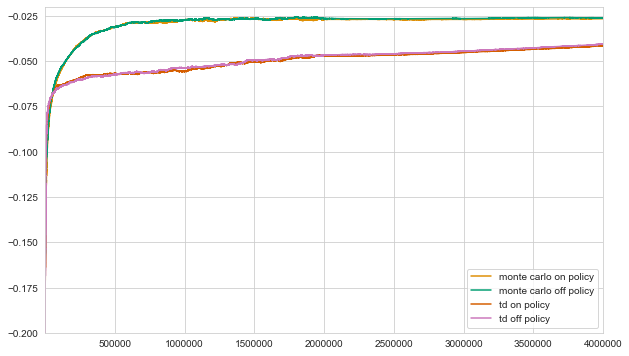

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(mc_on_models[0].mean_rewards_log)+ 1

ax.plot(np.arange(1, max_x), mc_on_res, 
            label=f"monte carlo on policy", color=f"C1")

ax.plot(np.arange(1, max_x), mc_off_res, 
            label=f"monte carlo off policy", color=f"C2")

ax.plot(np.arange(1, max_x), td_on_res, 
            label=f"td on policy", color=f"C3")

ax.plot(np.arange(1, max_x), td_off_res, 
            label=f"td off policy", color=f"C4")

ax.legend(loc="lower right")
ax.set_xlim((10, max_x))
ax.set_ylim((-0.2, -0.02))

(-0.05, -0.02)

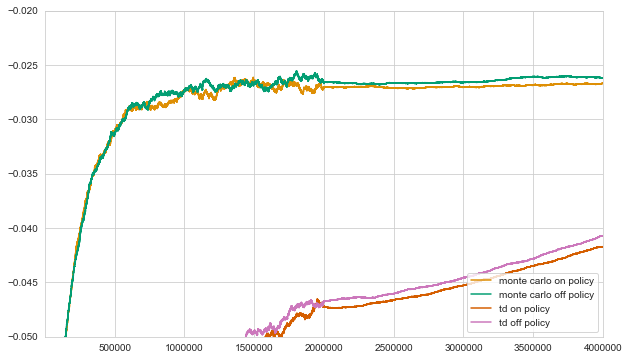

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(mc_on_models[0].mean_rewards_log)+ 1

ax.plot(np.arange(1, max_x), mc_on_res, 
            label=f"monte carlo on policy", color=f"C1")

ax.plot(np.arange(1, max_x), mc_off_res, 
            label=f"monte carlo off policy", color=f"C2")

ax.plot(np.arange(1, max_x), td_on_res, 
            label=f"td on policy", color=f"C3")

ax.plot(np.arange(1, max_x), td_off_res, 
            label=f"td off policy", color=f"C4")

ax.legend(loc="lower right")
ax.set_xlim((10, max_x))
ax.set_ylim((-0.05, -0.02))

In [ ]:
# Оценка итоговой модели
total_episodes = 1000000
mc_off_model_expectations = []

for model in tqdm(mc_off_models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    mc_off_model_expectations.append(expectation_i)

In [ ]:
# Оценка итоговой модели
total_episodes = 1000000
mc_on_model_expectations = []

for model in tqdm(mc_on_models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    mc_on_model_expectations.append(expectation_i)

In [ ]:
# Оценка итоговой модели
total_episodes = 1000000
td_on_model_expectations = []

for model in tqdm(td_on_models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    td_on_model_expectations.append(expectation_i)

In [ ]:
# Оценка итоговой модели
total_episodes = 1000000
td_off_model_expectations = []

for model in tqdm(td_off_models): 
    expectation_i = monto_carlo_expectation(env, model.pi, total_episodes = total_episodes)
    td_off_model_expectations.append(expectation_i)

Выводы и из сравнения методов: Monte carlo - сходиться быстрее, off policy - оценки чуть-чуть точнее

### Шаг обновления для td - обучения

In [110]:
q_learning_model = Td_learning_runner(off_policy = True, window_episodes = 50000, verbose = True)

In [112]:
%%time
q_learning_model.run(env, total_episodes = 500000, eps_value = 0.10, alpha_Q = 0.01, alpha_mean = 0.00001)

step: 49999 reward pi_eps: -0.0903, reward pi: -0.0570
step: 99999 reward pi_eps: -0.0879, reward pi: -0.0534
step: 149999 reward pi_eps: -0.0854, reward pi: -0.0499
step: 199999 reward pi_eps: -0.0776, reward pi: -0.0426
step: 249999 reward pi_eps: -0.0725, reward pi: -0.0381
step: 299999 reward pi_eps: -0.0706, reward pi: -0.0358
step: 349999 reward pi_eps: -0.0720, reward pi: -0.0363
step: 399999 reward pi_eps: -0.0700, reward pi: -0.0340
step: 449999 reward pi_eps: -0.0660, reward pi: -0.0300
step: 499999 reward pi_eps: -0.0682, reward pi: -0.0317
Wall time: 55 s


In [394]:
ex = monto_carlo_expectation(env, q_learning_model.pi, total_episodes = 2000000)
print(f'mean_reward {ex[0]:2.4f} +- {ex[1]:2.5f}')

mean_reward -0.0257 +- 0.00069


(-0.03, -0.02)

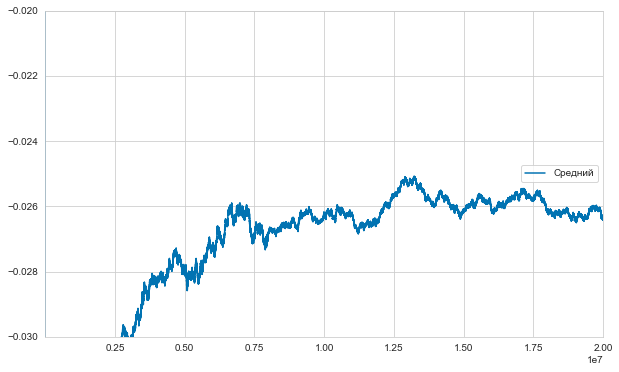

In [398]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1, len(q_learning_model.mean_rewards_log)+ 1), q_learning_model.mean_rewards_log, 
        label="Средний", color="C0")

ax.legend(loc="center right")
ax.set_xlim((1, len(q_learning_model.mean_rewards_log)+1))
ax.set_ylim((-0.03, -0.02))

In [144]:
num_runs = 3 # Число запусков

list_alpha = [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]

td_results = []
for j, alpha in enumerate(tqdm(list_alpha)):
    print(f'Расчет для параметра alpha_Q: {alpha}')
    for i in range(num_runs):

        td_model = Td_learning_runner(off_policy = True, window_episodes = 10000, verbose = False)
        td_model.run(env, total_episodes = 50000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = min(0.0005, alpha / 20))
        td_model.run(env, total_episodes = 150000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = min(0.0001, alpha / 20))
        td_model.run(env, total_episodes = 300000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = 0.00002)
        td_model.run(env, total_episodes = 500000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = 0.00001)
        td_model.run(env, total_episodes = 1000000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = 0.000005)
        td_model.run(env, total_episodes = 1000000, eps_value = 0.1, alpha_Q = alpha, alpha_mean = 0.000002)
        
        if i == 0:
            td_res = np.array(td_model.mean_rewards_log)
        else:
            td_res = td_res +np.array(td_model.mean_rewards_log)

    td_res = td_res / num_runs

    td_results.append(td_res)

Расчет для параметра alpha_Q: 0.1
Расчет для параметра alpha_Q: 0.03
Расчет для параметра alpha_Q: 0.01
Расчет для параметра alpha_Q: 0.003
Расчет для параметра alpha_Q: 0.001
Расчет для параметра alpha_Q: 0.0003
Расчет для параметра alpha_Q: 0.0001



(-0.1, -0.02)

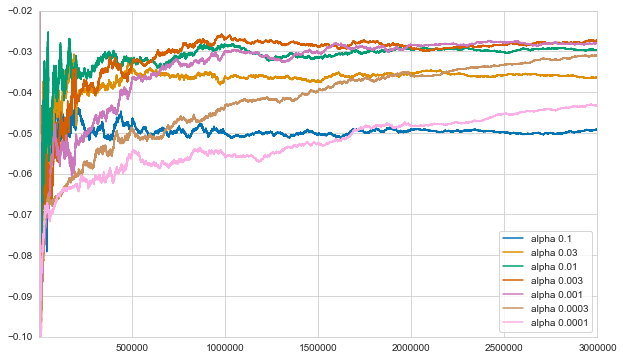

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

max_x = len(td_results[0])+ 1

for j, alpha in enumerate(list_alpha):
    ax.plot(np.arange(1, max_x), td_results[j], 
                label=f"alpha {alpha}", color=f"C{j}")


ax.legend(loc="lower right")
ax.set_xlim((1, max_x))
ax.set_ylim((-0.1, -0.02))

In [147]:
for j, alpha in enumerate(list_alpha):
    print(alpha, np.mean(td_results[j][2500000:]))

0.1 -0.04991326565057194
0.03 -0.03592265205544401
0.01 -0.029545156331764275
0.003 -0.027917474875224498
0.001 -0.02807292033926166
0.0003 -0.03202731715956463
0.0001 -0.04422715050115281


Итого 
<table style="width:60%">
<tr>
<th>alpha</th>
<th>Reward</th>
<th>Скорость сходимости</th>
</tr>

<tr>
<td>0.1</td>
<td>-0.05</td>
<td>меньше 100 000</td>
</tr>

<tr>
<td>0.03</td>
<td>-0.036</td>
<td>200 000</td>
</tr>
    
<tr>
<td>0.01</td>
<td>-0.0295</td>
<td>1 000 000</td>
</tr>
    
<tr>
<td>0.003</td>
<td>-0.028</td>
<td>3 000 000</td>
</tr> 
    
<tr>
<td>0.001</td>
<td>-0.028</td>
<td>3 000 000</td>
</tr>   
    
<tr>
<td>0.0003</td>
<td>не сошелся</td>
<td>больше 3 000 000</td>
</tr>      
    
</table>


Шаг сильно влияет на скорость обучения и на финальное качество модели. 

## Часть вторая, удвоение ставок

Добавим действие: double — удвоить ставку; при этом больше действий делать нельзя, игроку
выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш
удваивается

In [71]:
# game const
NUMBER_STATES = 640 
NUMBER_ACTIONS = 3

ACTION_STICK = 0
ACTION_HIT = 1
ACTION_DOUBLE = 2

In [72]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # three actions
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: #double
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2.
                
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [83]:
env = BlackjackDoubleEnv(natural = True)

In [84]:
monte_carlo_model = Monte_carlo_control_runner(total_episodes = 10000, gamma = 1.00, eps_value = 0.05, off_policy = True,
                                               alpha_mean = 0.000001, verbose = True, window_episodes = 500000)

In [85]:
monte_carlo_model.run(env, total_episodes = 5000000, eps_value = 0.05, alpha_mean = 0.000002)

step: 499999 reward pi_eps: -0.0771, reward pi: -0.0499
step: 999999 reward pi_eps: -0.0616, reward pi: -0.0334
step: 1499999 reward pi_eps: -0.0548, reward pi: -0.0253
step: 1999999 reward pi_eps: -0.0501, reward pi: -0.0197
step: 2499999 reward pi_eps: -0.0479, reward pi: -0.0171
step: 2999999 reward pi_eps: -0.0467, reward pi: -0.0149
step: 3499999 reward pi_eps: -0.0465, reward pi: -0.0148
step: 3999999 reward pi_eps: -0.0472, reward pi: -0.0154
step: 4499999 reward pi_eps: -0.0452, reward pi: -0.0137
step: 4999999 reward pi_eps: -0.0448, reward pi: -0.0127


In [86]:
# Проверка качества оценивания налету с помощью монте карло оценки финальной модели
ex = monto_carlo_expectation(env, monte_carlo_model.pi, total_episodes = 2000000)
print(f'Cредний результат стратегии {ex[0]:2.4f} +- {ex[1]:2.4f}')

Cредний результат стратегии -0.0122 +- 0.0008


(-0.1, -0.01)

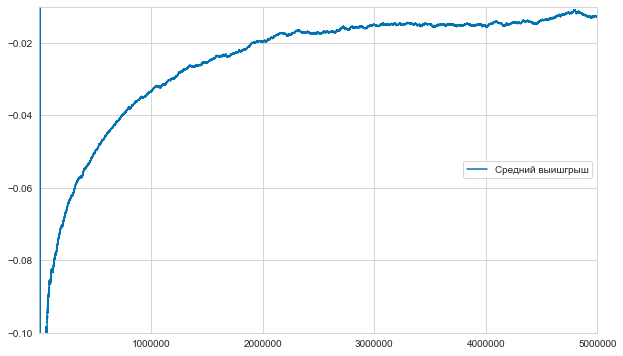

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1, len(monte_carlo_model.mean_rewards_log)+ 1), monte_carlo_model.mean_rewards_log, 
        label="Средний выишгрыш", color="C0")

ax.legend(loc="center right")
ax.set_xlim((1, len(monte_carlo_model.mean_rewards_log)+1))
ax.set_ylim((-0.1, -0.01))

## Часть третья

Окружение с учетом исчерпания колоды

Для простоты алгоритма обучения подсчет карт реализован в окружении, так что на выходе только дополнительный балл

In [15]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, ]
        
NUM_CARDS = int(52)    
NUM_SCORES = int(21)
MAX_SCORE = int(NUM_SCORES / 2)




class BlackjackDoubleCardEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # three actions
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.used_cards = [True for _ in range(52)]
        self.num_userd_cards = 0
        
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def draw_card(self):
        choice = -1
        while True:
            i = self.np_random.randint(0, NUM_CARDS)
            if self.used_cards[i]:
                self.used_cards[i] = False
                choice = deck[i]
                break
        self.num_userd_cards += 1        
        return int(choice)

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)


    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)    

    def score_out_card(self, card):  # What is the score of this hand (0 if bust)
        score = 0 
        if card in (2, 7):
            score += 0.5
        elif card in (3, 4, 6):    
            score += 1.0
        elif card == 5:
            score += 1.5
        elif card == 8:
            score += 0
        elif card == 9:
            score += -0.5        
        else:
            score += -1.0   

        return score

    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 2: #double
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = cmp(self.score(self.player), self.score(self.dealer)) * 2.
                
        else:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    
    def _get_obs(self):
        scores = int(sum([self.score_out_card(deck[i]) for i in range(NUM_CARDS) if not self.used_cards[i]]))
        scores = MAX_SCORE + min(MAX_SCORE, max(-MAX_SCORE, scores))
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player), scores)

    def reset(self):
        if self.num_userd_cards > (52 - 15):
            self.num_userd_cards = 0
            self.used_cards = [True for _ in range(52)]
        
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

In [3]:
# game const
NUMBER_STATES = 640 * NUM_SCORES
NUMBER_ACTIONS = 3

ACTION_STICK = 0
ACTION_HIT = 1
ACTION_DOUBLE = 2

def transfom_state_to_id(state):
    state_id = (state[0] - 1) + 32 * state[2] + 64 * (state[1] - 1) + 640 * (state[3] - 1)
    return state_id

def get_state_id(env):
    return transfom_state_to_id(env._get_obs())


def transfom_id_to_state(state_id):
    state = ((state_id % 32) + 1,
             (state_id // 64) + 1,
             ((state_id // 32) % 2) == 1,
             (state_id // 640) + 1
            )
    return state

In [18]:
env = BlackjackDoubleCardEnv(natural=True)

Однократный запуск модели

In [19]:
mc_count_model = Monte_carlo_control_runner(off_policy = True, total_episodes = 10000, eps_value = 0.1, verbose = True, window_episodes = 1000000)

In [20]:
%%time
mc_count_model.run(env, total_episodes = 20000000, eps_value = 0.1, alpha_mean = 0.000002)

step: 999999 reward pi_eps: -0.0965, reward pi: -0.0456
step: 1999999 reward pi_eps: -0.0728, reward pi: -0.0168
step: 2999999 reward pi_eps: -0.0681, reward pi: -0.0083
step: 3999999 reward pi_eps: -0.0631, reward pi: -0.0028
step: 4999999 reward pi_eps: -0.0634, reward pi: -0.0016
step: 5999999 reward pi_eps: -0.0594, reward pi: 0.0021
step: 6999999 reward pi_eps: -0.0593, reward pi: 0.0032
step: 7999999 reward pi_eps: -0.0593, reward pi: 0.0029
step: 8999999 reward pi_eps: -0.0573, reward pi: 0.0053
step: 9999999 reward pi_eps: -0.0569, reward pi: 0.0050
step: 10999999 reward pi_eps: -0.0558, reward pi: 0.0064
step: 11999999 reward pi_eps: -0.0565, reward pi: 0.0054
step: 12999999 reward pi_eps: -0.0565, reward pi: 0.0053
step: 13999999 reward pi_eps: -0.0546, reward pi: 0.0067
step: 14999999 reward pi_eps: -0.0530, reward pi: 0.0084
step: 15999999 reward pi_eps: -0.0560, reward pi: 0.0059
step: 16999999 reward pi_eps: -0.0552, reward pi: 0.0076
step: 17999999 reward pi_eps: -0.0531

In [21]:
%%time
monto_carlo_expectation(env, mc_count_model.pi, total_episodes = 1000000)

Wall time: 2min 35s


(0.007682, 0.0011234097591155243)

Многократный запус для проверки 

In [425]:
class Stats_MC_count:
    def __init__(self):
        steps = []
        scores = []
        std_scores = []
    
stats_MC_count = Stats_MC_count()
stats_MC_count.steps = []
stats_MC_count.scores = []
stats_MC_count.std_scores = []

In [439]:
%%time
for iteration in range(5):
    mc_count_model.run(env, total_episodes = 1000000, eps_value = 0.1, alpha_mean = 0.0000005)
    score, score_std = monto_carlo_expectation(env, mc_count_model.pi, total_episodes = 2000000)
    stats_MC_count.steps.append(len(mc_count_model.mean_rewards_log))
    stats_MC_count.scores.append(score)
    stats_MC_count.std_scores.append(score_std)
    print(f'iteration: {iteration}, steps: {stats_MC_count.steps[-1]}, m_reward: {stats_MC_count.scores[-1]:2.4f}, std_reward: {stats_MC_count.std_scores[-1]:2.4f}')

step: 99999 reward_eps -0.0562, reward_pi 0.0064
step: 199999 reward_eps -0.0561, reward_pi 0.0064
step: 299999 reward_eps -0.0560, reward_pi 0.0066
step: 399999 reward_eps -0.0560, reward_pi 0.0067
step: 499999 reward_eps -0.0558, reward_pi 0.0070
step: 599999 reward_eps -0.0556, reward_pi 0.0073
step: 699999 reward_eps -0.0555, reward_pi 0.0073
step: 799999 reward_eps -0.0555, reward_pi 0.0073
step: 899999 reward_eps -0.0555, reward_pi 0.0074
step: 999999 reward_eps -0.0556, reward_pi 0.0073
iteration: 0, steps: 17000000, m_reward: 0.0058, std_reward: 0.0008
step: 99999 reward_eps -0.0558, reward_pi 0.0071
step: 199999 reward_eps -0.0555, reward_pi 0.0073
step: 299999 reward_eps -0.0554, reward_pi 0.0073
step: 399999 reward_eps -0.0554, reward_pi 0.0073
step: 499999 reward_eps -0.0554, reward_pi 0.0075
step: 599999 reward_eps -0.0552, reward_pi 0.0076
step: 699999 reward_eps -0.0551, reward_pi 0.0078
step: 799999 reward_eps -0.0552, reward_pi 0.0078
step: 899999 reward_eps -0.0554, r

(-0.05, 0.01)

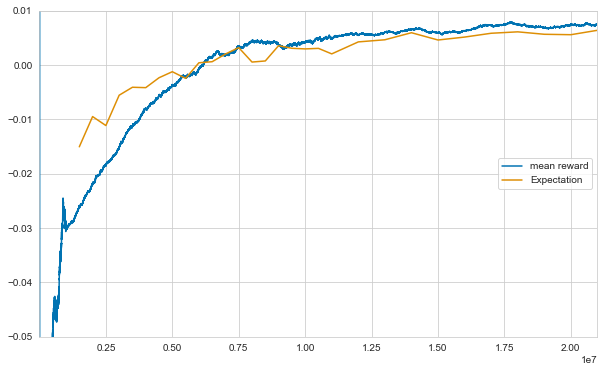

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1, len(mc_count_model.mean_rewards_log)+ 1), mc_count_model.mean_rewards_log, 
        label="mean reward", color="C0")

ax.plot(np.array(stats_MC_count.steps), np.array(stats_MC_count.scores), 
        label="Expectation", color="C1")

ax.legend(loc="center right")
ax.set_xlim((1, len(mc_count_model.mean_rewards_log)+1))
ax.set_ylim((-0.05, 0.01))

Итоговые результы: 

<table style="width:80%">
<tr>
<th>Задача</th>
<th>Выигрыш наилучшей модели</th>
</tr>

<tr>
<td>Часть первая, прострые правила</td>
<td>-0.026</td>
</tr>

<tr>
<td>Часть вторая, удвоение ставок</td>
<td>-0.0122</td>
</tr>
    
<tr>
<td>Часть третья, подсчет карт</td>
<td>0.0076</td>
</tr>
    
</table>